In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

np.random.seed(100)

In [2]:
# Mount Google Drive.
drive.mount("/content/drive")

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

! mkdir kaggle_data
! unzip  "challenges-in-representation-learning-facial-expression-recognition-challenge.zip" -d kaggle_data

# Unmount Google Drive
drive.flush_and_unmount()

Mounted at /content/drive
100% 285M/285M [00:01<00:00, 225MB/s]
100% 285M/285M [00:01<00:00, 188MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: kaggle_data/example_submission.csv  
  inflating: kaggle_data/fer2013.tar.gz  
  inflating: kaggle_data/icml_face_data.csv  
  inflating: kaggle_data/test.csv    
  inflating: kaggle_data/train.csv   


In [3]:
# convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [4]:
# Plot metrics acc, val_acc and loss, val_loss
def plot_metrics(history, suptitle):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(history.history['loss']))

    # Plot accuracy
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='accuracy')
    plt.plot(epochs_range, val_acc, label='validation_accurancy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('accuracy and validation_accurancy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='loss')
    plt.plot(epochs_range, val_loss, label='validation_loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('loss and validation_loss')

    plt.suptitle(suptitle, fontsize=20)
    plt.show()
    return



---

# Datapreparation

In [5]:
df_data = pd.read_csv('/content/kaggle_data/icml_face_data.csv')

In [6]:
label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [7]:
df_data[' pixels'] = df_data[' pixels'].apply(lambda x: string2array(x))

<Axes: ylabel='emotion'>

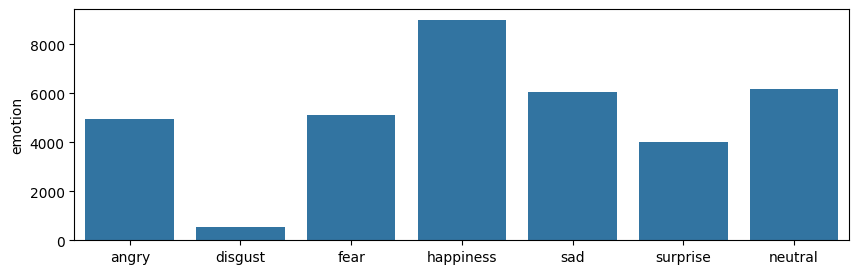

In [17]:
plt.figure(figsize = (10,3))
sns.barplot(x = label_to_text, y = df_data.emotion.value_counts())

In [8]:
# Separate data based on 'Usage' column
train_data = df_data[df_data[' Usage'] == 'Training']
test_data = df_data[df_data[' Usage'] == 'PublicTest']
val_data = df_data[df_data[' Usage'] == 'PrivateTest']

In [9]:
# one-hot
x_train = train_data[' pixels']
y_train = to_categorical(train_data['emotion'])

x_test = test_data[' pixels']
y_test = to_categorical(test_data['emotion'])

x_val = val_data[' pixels']
y_val = to_categorical(val_data['emotion'])

In [10]:
x_train = np.stack(x_train, axis = 0)
x_train = x_train.reshape(28709 , 48, 48, 1)

x_test = np.stack(x_test, axis = 0)
x_test = x_test.reshape(3589 , 48, 48, 1)

x_val = np.stack(x_val, axis = 0)
x_val = x_val.reshape(3589 , 48, 48, 1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)
(3589, 48, 48, 1) (3589, 7)


In [11]:
# Calculate the average class count
average_class_count = df_data['emotion'].value_counts().mean()

In [12]:
# Separate data for each class
class_data = [df_data[df_data['emotion'] == i] for i in range(7)]

In [13]:
# Oversample to balance classes based on average class count
oversampled_data = [resample(class_df, replace=True, n_samples=int(average_class_count), random_state=42) for class_df in class_data]
balanced_data = pd.concat(oversampled_data)

<Axes: ylabel='emotion'>

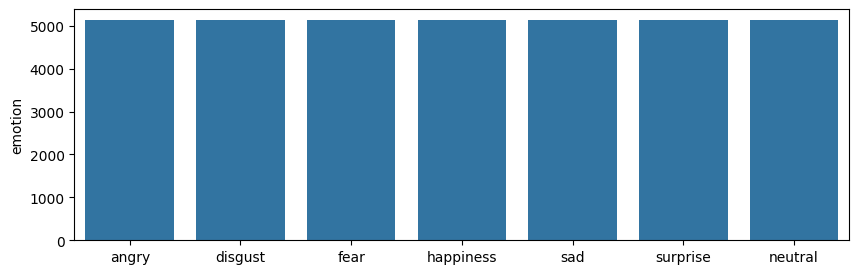

In [18]:
plt.figure(figsize = (10,3))
sns.barplot(x = label_to_text, y = balanced_data.emotion.value_counts())

In [14]:
# hold-out validation
x_train, x_temp, y_train, y_temp = train_test_split(balanced_data[' pixels'], balanced_data['emotion'], test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [15]:
print("Train set size:", x_train.shape[0])
print("Validation set size:", x_val.shape[0])
print("Test set size:", x_test.shape[0])

Train set size: 28705
Validation set size: 3588
Test set size: 3589


In [19]:
# one-hot
y_train = to_categorical(y_train)

y_test = to_categorical(y_test)

y_val = to_categorical(y_val)

In [20]:
# reshape
x_train = np.stack(x_train, axis = 0)
x_train = x_train.reshape(28705 , 48, 48, 1)

x_test = np.stack(x_test, axis = 0)
x_test = x_test.reshape(3589 , 48, 48, 1)

x_val = np.stack(x_val, axis = 0)
x_val = x_val.reshape(3588 , 48, 48, 1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(28705, 48, 48, 1) (28705, 7)
(3589, 48, 48, 1) (3589, 7)
(3588, 48, 48, 1) (3588, 7)




---

# Modeling

In [21]:
def create_model(learning_rate, regularization_rate=0, dropout_rate = 0, input_shape=(48,48,1)):

  base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                                 include_top=False,
                                                 weights='imagenet')

  # Inputlayer
  input = tf.keras.layers.Input(name='0_Input',
                                shape=input_shape)

  # Preprocessing stage
  x = tf.keras.layers.Resizing(name='1_Preprocessing_1',height = 96, width = 96)(input)
  x = tf.keras.layers.Rescaling(name='1_Preprocessing_2',
                                scale = 1/127.0, offset=-1)(x)
  x = tf.keras.layers.RandomRotation(name='1_Preprocessing_3',
                                     factor=0.20,
                                     seed=100)(x)
  x = tf.keras.layers.RandomFlip(name='1_Preprocessing_4',
                                 mode="horizontal",
                                 seed=100)(x)
  x = tf.keras.layers.Conv2D(name='1_Preprocessing_5',
                             filters=3,
                             kernel_size=(1, 1),
                             padding='same',
                             activation='tanh')(x)

  # Feature extracting stage
  x = base_model(x)
  x = tf.keras.layers.Flatten(name='3_Classification_1')(x)

  # Classification stage
  x = tf.keras.layers.Dense(name='3_Classification_2',
                            units=256,
                            kernel_regularizer=tf.keras.regularizers.l2(l2=regularization_rate),
                            kernel_initializer = 'he_uniform',
                            activation='relu')(x)
  x = tf.keras.layers.BatchNormalization(name='3_Classification_3')(x)
  x = tf.keras.layers.Dropout(name='3_Classification_4',
                              rate=dropout_rate)(x)
  # Prediction stage
  predictions = tf.keras.layers.Dense(name='4_Prediction',
                                      units = 7,
                                      kernel_initializer = 'zeros',
                                      activation=tf.nn.softmax)(x)

  keras_model = Model(inputs=input, outputs=predictions)

  keras_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

  return keras_model, base_model

In [ ]:
# Parameter
batch_size = 32

epochs = 100

learning_rate = 0.0001

dropout_rate = 0.4

regularization_rate = 0.1

es_patience = 15

lrp_patience = 10

lrp_factor = 0.1

In [ ]:
reg_model, base_model = create_model(learning_rate = learning_rate,
                                     dropout_rate = dropout_rate,
                                     regularization_rate = regularization_rate)

# freeze layers
for layer in reg_model.layers[:7]:
    layer.trainable = False

base_model.trainable = False

reg_model.summary(show_trainable=True)

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 0_Input (InputLayer)        [(None, 48, 48, 1)]       0         N          
                                                                            
 1_Preprocessing_1 (Resizin  (None, 96, 96, 1)         0         N          
 g)                                                                         
                                                                            
 1_Preprocessing_2 (Rescali  (None, 96, 96, 1)         0         N          
 ng)                                                                        
                                                                            
 1_Preprocessing_3 (RandomR  (None, 96, 96, 1)         0         N          
 otation)                                                                  



---



In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.3 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = 'orange'
color_map[tf.keras.layers.Input]['fill'] = 'gray'
color_map[tf.keras.layers.Dropout]['fill'] = 'pink'
color_map[tf.keras.layers.Resizing]['fill'] = 'red'
color_map[tf.keras.layers.Dense]['fill'] = 'green'
color_map[tf.keras.layers.Flatten]['fill'] = 'teal'
color_map[tf.keras.layers.BatchNormalization]['fill'] = 'black'

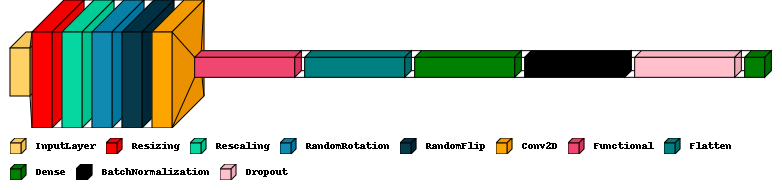

In [ ]:
import visualkeras
visualkeras.layered_view(reg_model, legend=True, scale_xy=1, scale_z=1, max_z=100, color_map=color_map)



---
# Training


In [ ]:
early_stopping = EarlyStopping(patience=es_patience, restore_best_weights=False)

lrp_reducer = ReduceLROnPlateau(monitor='val_loss', factor=lrp_factor, patience=lrp_patience, verbose=1)

In [ ]:
# training
t_start = time.time()

reg_hist = reg_model.fit(x_train,
                         y_train,
                         batch_size=batch_size,
                         epochs = epochs,
                         validation_data = (x_val,y_val),
                         callbacks = [lrp_reducer, early_stopping])

t_end = time.time()
reg_t_duration = t_end - t_start

Epoch 1/100
898/898 [==============================] - 83s 51ms/step - loss: 5.5372 - accuracy: 0.4056 - val_loss: 2.0837 - val_accuracy: 0.2433 - lr: 1.0000e-04
Epoch 2/100
898/898 [==============================] - 44s 49ms/step - loss: 1.3826 - accuracy: 0.5319 - val_loss: 2.1186 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 3/100
898/898 [==============================] - 42s 47ms/step - loss: 1.2571 - accuracy: 0.5805 - val_loss: 2.0542 - val_accuracy: 0.2887 - lr: 1.0000e-04
Epoch 4/100
898/898 [==============================] - 43s 48ms/step - loss: 1.1636 - accuracy: 0.6153 - val_loss: 1.5365 - val_accuracy: 0.4746 - lr: 1.0000e-04
Epoch 5/100
898/898 [==============================] - 41s 45ms/step - loss: 1.0942 - accuracy: 0.6391 - val_loss: 1.2180 - val_accuracy: 0.5719 - lr: 1.0000e-04
Epoch 6/100
898/898 [==============================] - 44s 49ms/step - loss: 1.0302 - accuracy: 0.6632 - val_loss: 1.0591 - val_accuracy: 0.6508 - lr: 1.0000e-04
Epoch 7/100
898/898 [=======



---

# Validation

In [ ]:
# validation
reg_score, reg_acc = reg_model.evaluate(x=x_test, y=y_test)
print('Test Loss =', reg_score)
print('Test Accuracy =', reg_acc*100)

113/113 [==============================] - 28s 227ms/step - loss: 0.7973 - accuracy: 0.8434
Test Loss = 0.7973132729530334
Test Accuracy = 84.34104323387146


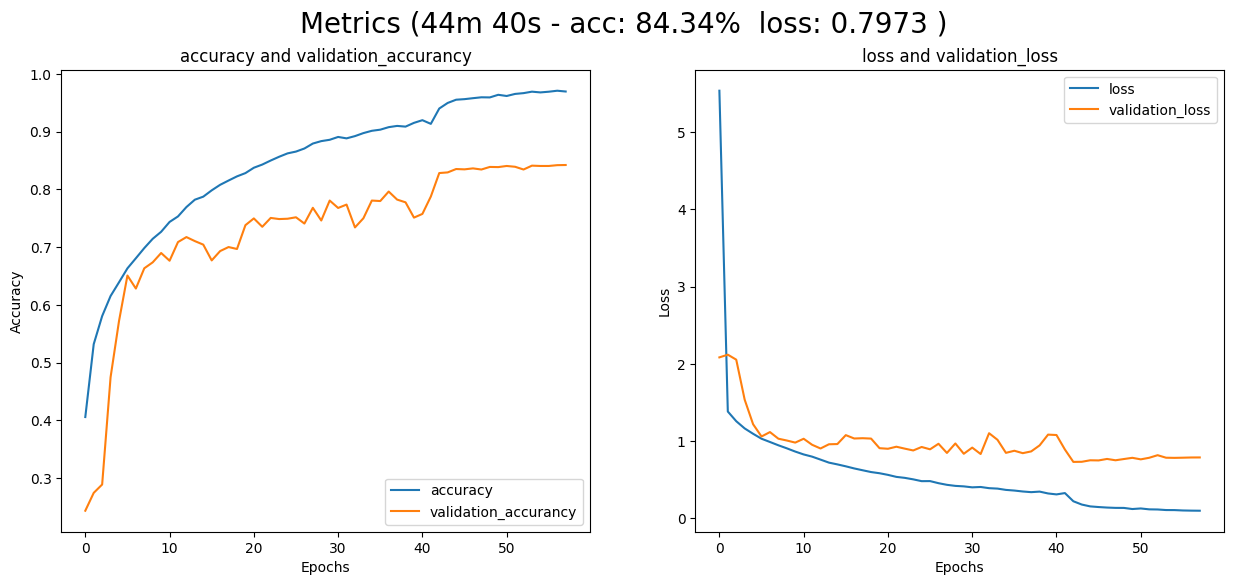

Accuracy: 84.34%
Loss:  0.7973136901855469
Epochs:  57
Train time : 44m 40s 

Batch Size: 32
initial learning rate: 0.0001
dropout rate: 0.4
Early Stopping patience: 15
ReduceLROnPlateau patience: 10
ReduceLROnPlateau factor: 0.1
Kernel Initializer: he_uniform
L2 regularization rate: 0.1
Batchnormalization: 0.9
Max_norm_value: 4


In [ ]:
train_time = '{:.0f}m {:.0f}s - acc: {:.2f}%  loss: {:.4f} '.format((reg_t_duration/60), (reg_t_duration%60), (reg_acc*100), reg_score)

plot_metrics(reg_hist, ('Metrics ('+ train_time+')'))

print('================================================')
print("Accuracy: %.2f%%" % (reg_acc * 100))
print("Loss:  %s" % reg_score)
print("Epochs:  %d" % max(range(len(reg_hist.history['loss']))))
print("Train time : %0.0fm %0.0fs \n" % (reg_t_duration/60, reg_t_duration%60))
print("Batch Size: %s" % batch_size)
print('================================================')
print("initial learning rate: %s" % learning_rate)
print("dropout rate: %s" % dropout_rate)
print("Early Stopping patience: %s" % es_patience)
print("ReduceLROnPlateau patience: %s" % lrp_patience)
print("ReduceLROnPlateau factor: %s" %lrp_factor)
print("Kernel Initializer: %s" % kernel_initializer)
print("L2 regularization rate: %s" % regularization_rate)
print("Batchnormalization: %s" % momentum)
print("Max_norm_value: %s" % max_norm_value)



---

ROC-Curve

In [ ]:
predictions = reg_model.predict(x_test)

113/113 [==============================] - 22s 196ms/step


In [ ]:
predictions = np.argmax(predictions, axis=1)

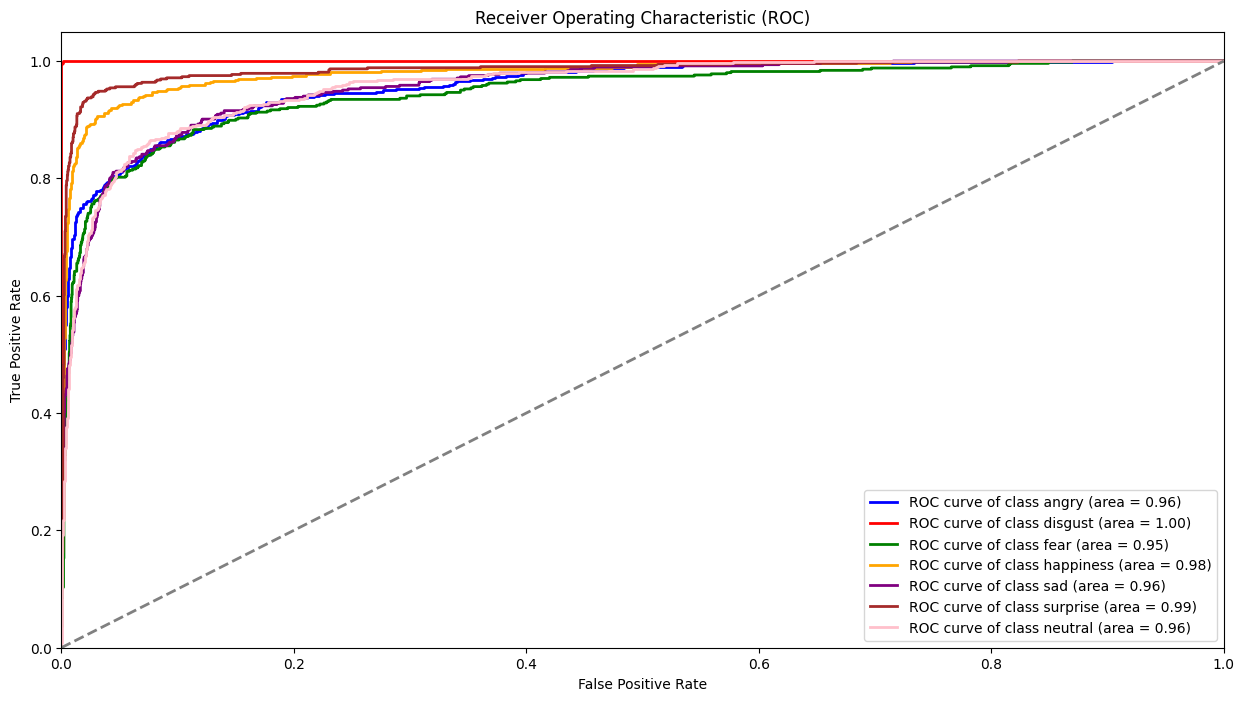

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(label_to_text[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

fig = plt.gcf()
fig.set_size_inches(15, 8)

plt.show()



---

Confusionmatrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
true_labels = np.argmax(y_test, axis=1)

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions)

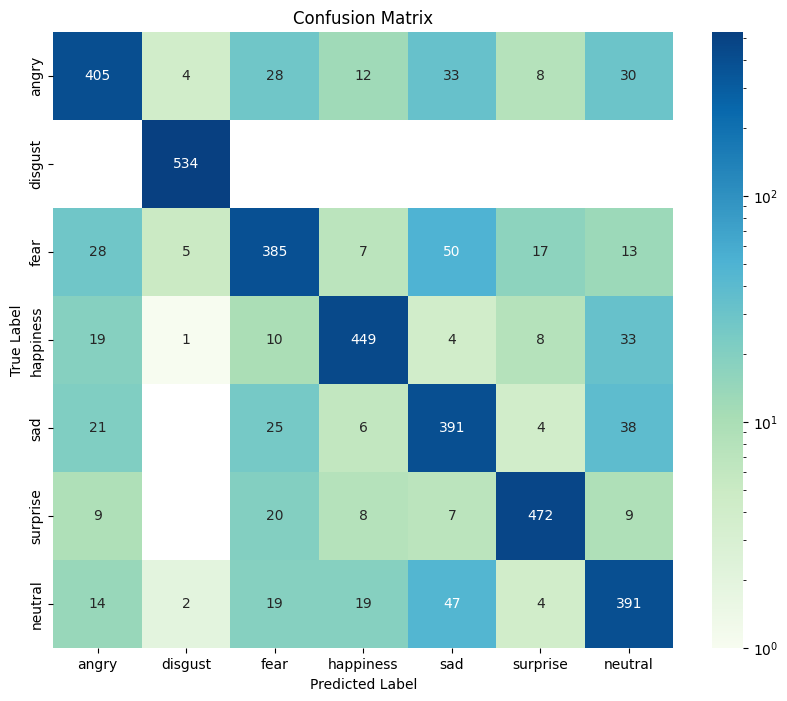

In [ ]:
from matplotlib.colors import LogNorm

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='GnBu', fmt='g', xticklabels=[label_to_text[i] for i in range(len(conf_matrix))], yticklabels=[label_to_text[i] for i in range(len(conf_matrix))], norm=LogNorm())

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

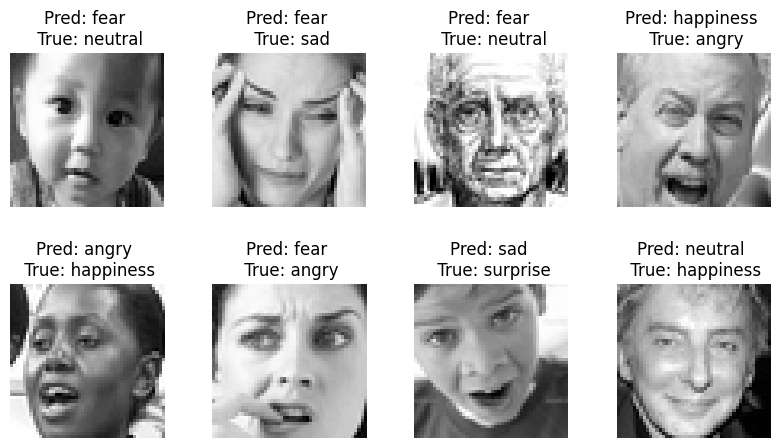

In [ ]:
# false predictions
incorrect_indices = np.where(predictions != true_labels)[0]
images = x_test

num_rows = 2
num_cols = 4

plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5)

for i, idx in enumerate(incorrect_indices[:num_rows * num_cols]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f'Pred: {label_to_text[predictions[idx]]} \n True: {label_to_text[true_labels[idx]]}')
    plt.axis('off')

plt.show()

In [ ]:
# f1-score
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predictions, average='weighted')

print("F1-Score:", f1)

F1-Score: 0.8437205690274927
